In [51]:
# Import
import csv
import glob
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import sys

## Content
### A. For general use:
* [A1. Similarity measures](#A1._Similarity_measures)
    * [A1.1. Set-theoretic measures (Intersection, Overlap, Jaccard, SMC, LCS, ngram_abs)](#A1.1.-Set-theoretic-measures-(Intersection,-Overlap,-Jaccard,-SMC,-LCS,-ngram_abs)) 
    * [A1.2. ITR measures](#A1.2.-ITR-measures)
        * [A1.2.1. Here we first calculate the observed, expected and maximum items of a specific unit size](#A1.2.1.-Here-we-first-calculate-the-observed,-expected-and-maximum-items-of-a-specific-unit-size)
        * [A1.2.2. Then, we summarize them in final metrics (e.g., OmE (Pair Frequency/SOMA), OdE, OmEdM, OdM, OmEdMmE)](#A1.2.2.-Then,-we-summarize-them-in-final-metrics-(e.g.,-OmE-(Pair-Frequency/SOMA),-OdE,-OmEdM,-OdM,-OmEdMmE))
    * [A1.3. Edit distance measures](#A1.3.-Edit-distance-measures)
    * [A1.4. Graveyard for old similarity measure functions](#A1.4.-Graveyard-for-old-similarity-measure-functions)

### B. Project specific: Data wrangling for experiments
* [B1. Experiment & Data overview](#B1.-Experiment-&-Data-overview)
* [B2. Pickle file conversion (old --> new)](#B2.-Pickle-file-conversion-(old--->-new))
* [B3. Data frame creation (incl. spell check); to be used for subsequent analysis](#B3.-Data-frame-creation-(incl.-spell-check);-to-be-used-for-subsequent-analysis)
* [B4. Similarity for dyads by sub-group](#B4.-Similarity-for-dyads-by-sub-group)
* [B5. Group means (Results presented in Manuscript)](#B5.-Group-means-(Results-presented-in-Manuscript))
* [B6. Correlation-Matrix (Results presented in Manuscript)](#B6.-Correlation-Matrix-(Results-presented-in-Manuscript))
-----------------------------------------------

### __A1. Similarity measures__
#### A1.1. Set-theoretic measures (Intersection, Overlap, Jaccard, SMC, LCS, ngram_abs)

In [12]:
def intersection(str1, str2):
    intersection = len(np.intersect1d(str1, str2))
    return intersection

In [13]:
def overlap(str1, str2):
    intersection = len(np.intersect1d(str1, str2))

    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str1) >= len(str2):
        larger = len(str1) 
        smaller = len(str2)
    else:
        smaller = len(str1)
        larger = len(str2) 
    overlap = intersection / smaller
    return overlap

In [14]:
def Jaccard(str1, str2): 
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    union = len(np.union1d(str1, str2))
    intersection = len(np.intersect1d(str1, str2))

    Jaccard = intersection / union
    #print(Jaccard)
    return Jaccard

In [15]:
def SMC(str1, str2): # This counts the number of muturally forgotten items as "similar". TBD in case of Experiments 1B and 3
    encoding = list(range(1,85)) + [157,158,159,160] # Manual entry to get all words from the original study list             
    
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    intersection = len(np.intersect1d(str1, str2))
    
    Forgotten = 0
    for word in encoding:
        if word in str1 or word in str2:
            continue
        else:
            Forgotten += 1
    
    return (((Forgotten+intersection) / len(encoding)))

In [16]:
def ngram_abs(str1, str2, unitSize, y, unidirectional=True):
    
    """
    USAGE:
    #of bigrams/trigrams/ngrams = ngram_abs(str1, str2, unitSize, y, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Order/Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    Can be used to calculate the joint number of word pairs/bigrams or triplets/trigrams across two participants
    """
     
    #str1 = str1.values.tolist()
    #str2 = str2.values.tolist()
    string1 = None
    string2 = None
    
    if unidirectional == True:
        #return [np.array(x) for x in zip(string[0:-1], string[1:])]
        iters = tee(str1, unitSize)                                                     
        for i, it in enumerate(iters):                                               
            next(islice(it, i, i), None)
            
        iters2 = tee(str2, unitSize)                                                     
        for i, it in enumerate(iters2):                                               
            next(islice(it, i, i), None)
           
        string1 = list(zip(*iters))
        string2 = list(zip(*iters2))
    else:
        s = list(str1)
        powerset = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
        s2 = list(str2)
        powerset2 = chain.from_iterable(combinations(s2, r) for r in range(len(s2)+1))
        string1 = [(x) for x in powerset if len(x)==unitSize]
        string2 = [(x) for x in powerset2 if len(x)==unitSize]
    #print(string1)
    #print(string2)

    # This is for assining unique numbers to the different n-grams. At the moment it is executed elsewhere,\ 
    # but one could also execute it in here
    #y = permu(unitSize)
    #all_p = pd.DataFrame()
    #all_p['AllPermutations'] = y
    
    a_list = []
    for i in (string1):
        if i in y:
            x = y.index(i)
        else:
            continue
        a_list.append(x)

    b_list = []
    for i in (string2):
        if i in y:
            x = y.index(i)
        else:
            continue
        b_list.append(x)
    
    count = 0
    for i in string1:
        if i in string1 and i in string2:
            count += 1
        else:
            count += 0
    #print(count)
    #a = np.array(a_list)
    #b = np.array(b_list)
    
    return count

In [17]:
# Adapted from source: https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Longest_common_substring#Python
def lcs(str1, str2):
    m = [[0] * (1 + len(str2)) for i in range(1 + len(str1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(str1)):
        for y in range(1, 1 + len(str2)):
            if str1[x - 1] == str2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    string = (str1[x_longest - longest: x_longest])
    lcs = len(string)
    #print(string)
    return lcs

#### __A1.2. ITR measures__
##### A1.2.1. Here we first calculate the observed, expected and maximum items of a specific unit size

In [18]:
def observed(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = observed(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the observed words of a specific unit size to be used in subsequent shared organization measures
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str1) == 0:
        return []
    elif len(str2) ==0:
        return []
            
    ob_freq = 0
    for i in range(len(str1)-1):
        p1 = str1[i]
        p2 = str1[i+1]
        if unitSize ==3:
            p3 = str1[i+2]
        elif unitSize ==4:
            p3 = str1[i+2]
            p4 = str1[i+3]

        if unitSize == 2:
            if p1 in str2 and p2 in str2:
                i1 = np.nonzero(np.array(str2) == p1)
                i2 = np.nonzero(np.array(str2) == p2)
                # Directionality. Difference absolute or not absolute
                if unidirectional == True:
                    if (i2[0] - i1[0]) == 1:
                        ob_freq += 1
                else:
                    if abs(i2[0] - i1[0]) == 1:
                        ob_freq += 1                
            
        elif unitSize == 3:
            if p1 in str2 and p2 in str2 and p3 in str2:
                i1 = np.nonzero(np.array(str2) == p1)
                i2 = np.nonzero(np.array(str2) == p2)
                i3 = np.nonzero(np.array(str2) == p3)
                # Directionality. Difference absolute or not absolute
                if unidirectional == True:
                    if (i2[0] - i1[0]) == 1 and (i3[0] - i1[0]) == 2 and (i3[0] - i2[0]) == 1:
                        ob_freq += 1
                else:
                    if abs(i2[0] - i1[0]) <= 2 and abs(i3[0] - i2[0]) <= 2 and abs(i3[0] - i1[0]) <= 2: # I think I might not need the last and
                        ob_freq += 1  
            
        elif unitSize == 4:
            if p1 in str2 and p2 in str2 and p3 in str2:
                i1 = np.nonzero(np.array(str2) == p1)
                i2 = np.nonzero(np.array(str2) == p2)
                i3 = np.nonzero(np.array(str2) == p3)
                i4 = np.nonzero(np.array(str2) == p4)
                # Directionality. Difference absolute or not absolute
                if unidirectional == True:
                    if (i4[0] - i1[0]) == 3 and (i3[0] - i1[0]) == 2 and (i2[0] - i1[0]) == 1 and \
                    (i4[0] - i2[0]) == 2 and (i4[0] - i3[0] == 1) and (i3[0]-i2[0] == 1):
                        ob_freq += 1
                else:
                    if \
                    abs(i2[0] - i1[0]) <= 3 and abs(i3[0] - i1[0]) <= 3 and abs(i4[0] - i1[0]) <= 3 and \
                    abs(i3[0] - i2[0]) <= 3 and abs(i4[0] - i2[0]) <= 3 and \
                    abs(i4[0] - i3[0]) <= 3: 
                        ob_freq += 1     
           
    return ob_freq

In [19]:
def expected_BB(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = expected_BB(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.) --> Is always 2 in this case
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the expected organization of word pairs to be used in subsequent shared organization measures
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    # This is only for pairs   
    if unitSize != 2:
        return "Use different expected calculation for higher order unit sizes"
    
    # Calc expected
    num_common_items = len(np.intersect1d(str1, str2))
    if unidirectional == True:
        x = 1
    else:
        x = 2
        
    exp_freq = (x*num_common_items*(num_common_items-1)) / float(len(str1)*len(str2))

    if num_common_items == 0:
        return 0
    else:
        return exp_freq

In [20]:
def expected_generalized(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = expected_BB(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the expected organization of word pairs to be used in subsequent shared organization measures: ((N-X-1)! * A * (M-X + 1-R)) / N!
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    
    # Calculate expected value according to Boulsfield & Boulsfield
    num_common_items = len(np.intersect1d(str1, str2))
    if unidirectional == True:
        x = 1
    else:
        x = 2
    exp_freq = (x*num_common_items*(num_common_items-1)) / float(len(str1)*len(str2))
    #print('x', x)
    
    return exp_freq

In [21]:
def maximum(str1, str2, unitSize, unidirectional=True):
    """
    USAGE:
    score = maximum(str1, str2, unitSize, unidirectional=True)

    ARGUMENTS:
    str1            The first string
    str2            The second string
    unitSize        Size of unit of interest (word pair, triple, quartuple etc.)
    unidirectional  Direction of unit (only 1-2 valid, or also 2-1)

    DESCRIPTION:
    This calculates the maximum possible organization of word pairs to be used in subsequent shared organization measures: (c - x + 1)
    """
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    num_common_items = len(np.intersect1d(str1, str2))

    if num_common_items == 0:
        return 0
    elif num_common_items == 1:
        return 0
    else:
        return (num_common_items - unitSize + 1)

##### A1.2.2. Then, we summarize them in final metrics (e.g., OmE (Pair Frequency/SOMA), OdE, OmEdM, OdM, OmEdMmE)

In [22]:
def OmE(str1, str2, unitSize, unidirectional=True):   
    """
    DESCRIPTION:
    Unidirectional & pair = ITR (Bousfield & Bousfield (1966))
    Bidirectional & pari = Pair(ed) Frequency (Anderson & Watts (1969); Rosner (1970))
    """
    
    if unidirectional==True:
        return observed(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)
    else:
        return observed(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)

In [23]:
def OdE(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    Referred to as Sequential Consistency by Sternberg & Tulving (1977), developed by Gorfein, Blair, & Rowland (1968)
    """
        
    if expected_BB(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return observed(str1, str2, unitSize, unidirectional=True) / expected_BB(str1, str2, unitSize, unidirectional=True)
        else:
            return observed(str1, str2, unitSize, unidirectional=False) / expected_BB(str1, str2, unitSize, unidirectional=False)


In [24]:
def OmEdM(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    Referred to as Sequential Consistency by Sternberg & Tulving (1977)
    Unidirectional pairs, Fagan (1968)
    Bidirectional pairs, Postman (1970)
    """
    
    if maximum(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return ((observed(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)) / maximum(str1, str2, unitSize, unidirectional=True))
        else:
            return ((observed(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)) / maximum(str1, str2, unitSize, unidirectional=False))

In [25]:
def OdM(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    For bidirectional pairs referred to as ITR(2) (Mandler & Dean (1969))
    """
    
    if maximum(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return (observed(str1, str2, unitSize, unidirectional=True) / maximum(str1, str2, unitSize, unidirectional=True))
        else:
            return (observed(str1, str2, unitSize, unidirectional=False) / maximum(str1, str2, unitSize, unidirectional=False))

In [26]:
def OmEdMmE(str1, str2, unitSize, unidirectional=True):
    """
    DESCRIPTION:
    Generally referred to as ARC' (Pellegrino (1971); Pellegrino & Battig (1974))
    """
    
    if maximum(str1, str2, unitSize, unidirectional=True)==0 and expected_BB(str1, str2, unitSize, unidirectional=True)==0:
        return 0
    else:
        if unidirectional==True:
            return ((observed(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)) / (maximum(str1, str2, unitSize, unidirectional=True) - expected_BB(str1, str2, unitSize, unidirectional=True)))
        else:
            return ((observed(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)) / (maximum(str1, str2, unitSize, unidirectional=False) - expected_BB(str1, str2, unitSize, unidirectional=False)))

### __A1.3. Edit distance measures__

In [27]:
def edit_dists(string1, string2, insert=True, delete=True, substitute=True, transpose=True):

    if len(string1) > len(string2):
        string1, string2 = string2, string1

    n1 = len(string1)
    n2 = len(string2)
    d = np.zeros((n1 + 1, n2 + 1), dtype=int)

    for i in range(n1 + 1):
        d[i, 0] = i

    for j in range(n2 + 1):
        d[0, j] = j

    for i in range(n1):
        for j in range(n2):
            options = []
            # insertion
            if insert:
                options += [d[i, j+1] + 1]
            # deletion
            if delete:
                options += [d[i+1, j] + 1]
            # substitution
            if substitute and not(string1[i] == string2[j]):
                options += [d[i, j] + 1]
            # identical entries are free
            elif string1[i] == string2[j]:
                options += [d[i, j] + 0]

            d[i+1, j+1] = min(options)
            #d[i+1, j+1] = min(d[i, j+1] + 1, # insert
            #                  d[i+1, j] + 1, # delete
            #                  d[i, j] + cost) # replace

            if transpose:
                if i > 0 and j > 0 and string1[i] == string2[j-1] and string1[i-1] == string2[j]:
                    d[i+1, j+1] = min(d[i+1, j+1], d[i-1, j-1] + int(not(string1[i] == string2[j]))) # transpose


    # if substitution, max # of edits is max(n1, n2)

    if substitute:
        return 1 - ( d[n1, n2] / max(n1, n2) )

    # otherwise, it's n1 + n2 (delete each of s1, then insert each of s2)
    else:
        return 1 - ( d[n1, n2] / (n1 + n2) )
    #return d

### __A1.4. Graveyard for old similarity measure functions__

In [28]:
def pairedFreq(str2, str1):
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str2) == 0:
        return []
    ob_freq = 0
    for i in range(len(str2)-1):
        p1 = str2[i]
        p2 = str2[i+1]
        if p1 in str1 and p2 in str1:
            i1 = np.nonzero(np.array(str1) == p1)
            i2 = np.nonzero(np.array(str1) == p2)
            if abs(i1[0] - i2[0]) == 1:
                ob_freq += 1
                #print(ob_freq)
    #print(str2)
    #print(str1)
    #print("ob_freq=", ob_freq)
    
    if str2 == []:
        return 0

    
    # This is the code from Christian
    # num_common_items = len(final)
    # 
    # num_common_items = np.intersect1d(final, orig)
    # print("num_common_items=", num_common_items)
    # 
    # if type(num_common_items) == np.dtype(int):
    #    num_common_items = 1
    # else:
    #    print(num_common_items)
    #    num_common_items = len(num_common_items)

    num_common_items = len(np.intersect1d(str1, str2)) #Alex New

    exp_freq = (2*num_common_items*(num_common_items-1)) / float(len(str2)*len(str1))
    #print("exp_freq=", exp_freq)
    PF = ob_freq - exp_freq
    #print("PF=", PF)
    return PF

In [29]:
# Normalized observed bidirectional Inter-Trial-Repetition (O(ITR2) - Max(ITR2)) (by Alex, build on adapted PF from Christian)
# "The maximum ITR value is a function of the number of items common to both sets of events and does not depend on the absolute 
# number of words recalled or presented. It is equal to the number of items common to both events minus one." (Mandler & Dean, 1969)
def ITR2(str1, str2, shortest = True):
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str2) == 0:
        return []
    ob_freq = 0
    for i in range(len(str2)-1):
        p1 = str2[i]
        p2 = str2[i+1]
        if p1 in str1 and p2 in str1:
            i1 = np.nonzero(np.array(str1) == p1)
            i2 = np.nonzero(np.array(str1) == p2)
            if abs(i1[0] - i2[0]) == 1:
                ob_freq += 1
    #print("ob_freq=", ob_freq)
    
    if str2 == []:
        return 0

    num_common_items = len(np.intersect1d(str1, str2))
    if num_common_items == 0: #Check with Christian
        ITR2 = 0
    elif num_common_items == 1:
        ITR2 = 0
    else:
        ITR2 = (ob_freq / (num_common_items - 1)) #M(ITR) = M(ITR2) = c-1
    
    return ITR2

In [30]:
# Different normalization for observed bidirectional Inter-Trial-Repetition 
# (O(ITR2) - E(ITR2)) / (M(ITR2) - E(ITR2)) (by Alex, build on adapted PF from Christian)
def ARC2(str1, str2):
    
    # Transform to correct input format, if it isn't already a list or a numpy array
    try:
        str1 = str1.values.tolist()
        str2 = str2.values.tolist()
    except:
        pass
    
    if len(str2) == 0:
        return []
    ob_freq = 0
    for i in range(len(str2)-1):
        p1 = str2[i]
        p2 = str2[i+1]
        if p1 in str1 and p2 in str1:
            i1 = np.nonzero(np.array(str1) == p1)
            i2 = np.nonzero(np.array(str1) == p2)
            if abs(i1[0] - i2[0]) == 1:
                ob_freq += 1
    #print("ob_freq=", ob_freq)
    
    if str2 == []:
        return 0

    num_common_items = len(np.intersect1d(str1, str2))
    #print("num_common_items=", num_common_items) 

    exp_freq = (2*num_common_items*(num_common_items-1)) / float(len(str2)*len(str1))
    #print("exp_freq=", exp_freq) 

    max_freq = (num_common_items - 1)
    #print("max_freq=", max_freq) 
    
    if (max_freq - exp_freq)== 0 : # Double check with Christian (happens when c=1)
        ARC2 = 0
        #print('watch out')
    else:
        ARC2 = (ob_freq - exp_freq) / (max_freq - exp_freq)
    #print(ob_freq, exp_freq, max_freq)
    return ARC2

In [31]:
def editdist(str1, str2, min_threshold = None):
  #"""Return approximate string comparator measure (between 0.0 and 1.0)
   #  using the edit (or Levenshtein) distance.

#  USAGE:
#    score = editdist(str1, str2, min_threshold)

#  ARGUMENTS:
#    str1           The first string
#    str2           The second string
#    min_threshold  Minimum threshold between 0 and 1
#
#  DESCRIPTION:
#    The edit distance is the minimal number of insertions, deletions and
#    substitutions needed to make two strings equal.#
#
#    For more information on the modified Soundex see:
#    - http://www.nist.gov/dads/HTML/editdistance.html
#  """

#  # Quick check if the strings are empty or the same - - - - - - - - - - - - -
#  #
#  #if (str1 == '') or (str2 == ''):
    if (str1.size == 0) or (str2.size == 0):
        return 0.0
    #if len(str1) == len(str2) and len(str1) > 1 and all(str1 == str2):
    #    return 1.0
    #elif len(str1) == len(str2) and len(str1) == 1 and (str1 == str2):
    #    return 1.0

    n = len(str1)
    m = len(str2)
    max_len = max(n,m)

    if (min_threshold != None):
        if (isinstance(min_threshold, float)) and (min_threshold > 0.0) and (min_threshold > 0.0):

            len_diff = abs(n-m)
            w = 1.0 - float(len_diff) / float(max_len)

            if (w  < min_threshold):
                return 0.0  # Similariy is smaller than minimum threshold

        else: # Calculate the maximum distance possible with this threshold
            max_dist = (1.0-min_threshold)*max_len

    else:
        logging.exception('Illegal value for minimum threshold (not between' + \
                        ' 0 and 1): %f' % (min_threshold))
        raise Exception

    if (n > m):  # Make sure n <= m, to use O(min(n,m)) space
        str1, str2 = str2, str1
        n, m =       m, n

    current = range(n+1)

    for i in range(1, m+1):

        previous = current
        current =  [i]+n*[0]
        str2char = str2[i-1]

        for j in range(1,n+1):
            substitute = previous[j-1]
            if (str1[j-1] != str2char):
                substitute += 1

      # Get minimum of insert, delete and substitute
      #
            current[j] = min(previous[j]+1, current[j-1]+1, substitute)

        if (min_threshold != None) and (min(current) > max_dist):
            return 1.0 - float(max_dist+1) / float(max_len)

    w = 1.0 - float(current[n]) / float(max_len)

    assert (w >= 0.0) and (w <= 1.0), 'Similarity weight outside 0-1: %f' % (w)

  # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  #
    logging.debug('Edit-distance comparator string "%s" with "%s" value: %.3f' \
                % (str1, str2, w))
    return w

In [32]:
def mod_editdist(str1, str2, min_threshold = None):
#Return approximate string comparator measure (between 0.0 and 1.0)
#     using a modified edit (or Levenshtein) distance that counts transpositions
#     as elementary operations as well. This is also called the Damerau-
#     Levenshtein distance.

#  USAGE:
#    score = mod_editdist(str1, str2, min_threshold)

#  ARGUMENTS:
#    str1           The first string
#    str2           The second string
#    min_threshold  Minimum threshold between 0 and 1

#  DESCRIPTION:
#    The edit distance is the minimal number of insertions, deletions,
#    substitutions and transpositions needed to make two strings equal.

#    Compared to the original editdist function, which handles a transposition
#    (like: 'sydney' <-> 'sydeny' as 2 operations (two substitutions or one
#    insert and one delet), this modified version handles this as 1 operation.

#    Based on code from Justin Zobel's 'vrank'.
    
# Quick check if the strings are empty or the same - - - - - - - - - - - - -
#
#if (str1 == '') or (str2 == ''):
#print([str1, str2])
    #assert(0)
    if (str1.size == 0) or (str2.size == 0):
        return 0.0
    #elif (str1 == str2):
    elif np.array_equal(str1, str2):
        return 1.0

    n = len(str1)
    m = len(str2)
    max_len = max(n,m)
    #print('n', n)
    #print('m', m)
    #print('max_len',max_len)

    if (min_threshold != None):
        if (isinstance(min_threshold, float)) and (min_threshold > 0.0) and (min_threshold > 0.0): #I don't get this one
        
            len_diff = abs(n-m)
            w = 1.0 - float(len_diff) / float(max_len)

            if (w  < min_threshold):
                return 0.0  # Similariy is smaller than minimum threshold

        else: # Calculate the maximum distance possible with this threshold
            max_dist = (1.0-min_threshold)*max_len

    else:
        logging.exception('Illegal value for minimum threshold (not between' + ' 0 and 1): %f' % (min_threshold))
        raise Exception

    if (n > m):  # Make sure n <= m, to use O(min(n,m)) space
        str1, str2 = str2, str1
        n, m =       m, n

    d = []  # Table with the full distance matrix

    current = range(n+1)
    d.append(current)

    for i in range(1,m+1):

        previous = current
        current =  [i]+n*[0]
        str2char = str2[i-1]

        for j in range(1,n+1):
            substitute = previous[j-1]
            if (str1[j-1] != str2char):
                substitute += 1

            if (i == 1) or (j == 1):  # First characters, no transposition possible

            # Get minimum of insert, delete and substitute
            #
                current[j] = min(previous[j]+1, current[j-1]+1, substitute)

            else:
                if (str1[j-2] == str2[i-1]) and (str1[j-1] == str2[i-2]):
                    transpose = d[i-2][j-2] + 1
                else:
                    transpose = d[i-2][j-2] + 3

                current[j] = min(previous[j]+1, current[j-1]+1, substitute, transpose)

        d.append(current)

        if (min_threshold != None) and (min(current) > max_dist):
            return 1.0 - float(max_dist+1) / float(max_len)

    w = 1.0 - float(current[n]) / float(max_len)
    
    assert (w >= 0.0) and (w <= 1.0), 'Similarity weight outside 0-1: %f' % (w)

  # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  #
    logging.debug('Modified edit-distance comparator string "%s" with "%s" ' % \
                (str1, str2) + 'value: %.3f' % (w))

    return w

-------------------------------
## __B. Project specific: Data wrangling for experiments__
### __B1. Experiment & Data overview__
__Import & spell check files__
* 3 types of relevant files: encoding, retrieval 1 and retrieval 2
* Encoding two different levels: biased/unbiased and counterbalancing
    * (un)biased: 0 at the end = unbiased, 1 at the end = biased; if unbiased, all 14 lists were encoded deeply
    * counterbalancing: SN odd & biased: lists 1-7 encoded shallowly; SN even & biased: lists 8-14 encoded shallowly
* Retrieval:
    * Last number indicates retrieval phase
    * If last number = 1, then difference between collaborative or individual retrieval: if the middle number is 0 = individual retrieval, middle number 1 = collaborative retrieval
    * However, if xy_1_1, then both SN numbers (x and y) were mentioned before

#### __B2. Pickle file conversion (old --> new)__

In [80]:
#------------------------------DESCRIPTION----------------------------------------
# Convert files to new pickle files

#------------------------------SCRIPT---------------------------------------------
first = 1
last = 7475 #the highest SN collaborating dyad

# Specify the folder
print('os.path', os.path)
path_code = os.path.realpath('Similarity_Exp1_git.ipynb')
dir = os.path.dirname(path_code)
path = dir + '\data\Experiment1'
print(path)


# Encoding
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('\encoding_' + str(subjectNumber) +'_1.pkl')
        destination = ('\\new_encoding_' + str(subjectNumber) +'_1.pkl')
        
        content = ''
        outsize = 0
        
        with open(path + original, 'rb') as infile:
            content = infile.read()
        with open(path + destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(path + destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
            except EOFError:
                pass

    except FileNotFoundError:
        pass

for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('\encoding_' + str(subjectNumber) +'_0.pkl')
        destination = ('\\new_encoding_' + str(subjectNumber) +'_0.pkl')

        content = ''
        outsize = 0
        with open(path + original, 'rb') as infile:
            content = infile.read()
        with open(path + destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(path + destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
            except EOFError:
                pass

    except FileNotFoundError:
        pass
    
# Retrieval 1
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('\\retrieve_' + str(subjectNumber) +'_0_1.pkl')
        destination = ('\\new_retrieve_' + str(subjectNumber) +'_0_1.pkl')

        
        content = ''
        outsize = 0
        with open(path + original, 'rb') as infile:
            content = infile.read()
        with open(path + destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(path + destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
            except EOFError:
                pass

    except FileNotFoundError:
        pass

for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('\\retrieve_' + str(subjectNumber) +'_1_1.pkl')
        destination = ('\\new_retrieve_' + str(subjectNumber) +'_1_1.pkl')

        content = ''
        outsize = 0
        with open(path + original, 'rb') as infile:
            content = infile.read()
        with open(path + destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(path + destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
            except EOFError:
                pass

    except FileNotFoundError:
        pass



# Retrieval 2
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    try:
        original = ('\\retrieve_' + str(subjectNumber) +'_0_2.pkl')
        destination = ('\\new_retrieve_' + str(subjectNumber) +'_0_2.pkl')

        content = ''
        outsize = 0
        with open(path + original, 'rb') as infile:
            content = infile.read()
        with open(path + destination, 'wb') as output:
            for line in content.splitlines():
                outsize += len(line) + 1
                output.write(line + str.encode('\n'))

        with open(path + destination, 'rb') as f:
            try:
                test = pickle.load(f, encoding='latin1')
            except EOFError:
                pass

    except FileNotFoundError:
        pass

os.path <module 'ntpath' from 'C:\\Users\\afron\\.conda\\envs\\Similarity\\lib\\ntpath.py'>
C:\Users\afron\Documents\04_PhD\03_Projects\03_Similarity\14_GithubRepo\Similarity\data\Experiment1


### __B3. Data frame creation (incl. spell check); to be used for subsequent analysis__

In [84]:
#------------------------------INPUT----------------------------------------------------------------

# Complete study list, includes the buffer words
studyList = ['apple', 'arms','banker','basil','blizzard','blouse','book','bookcase','calcium','canyon','cardinal','carnation',
             'cave','chair','cherry','chlorine','cinnamon','comic','cotton','crow','daffodil','denim','dentist','desk','doctor',
             'dress','dresser','drought','drum','eagle','engineer','essay','finch','flounder','flyer','grape','green','guppy','hail',
             'halibut','helium','hour','jacket','lamp','leather','lightning','linen','mercury','mountain','mustard','nectarine','newspaper',
             'nitrogen','nurse','ocean','orchid','oregano','organ','oxygen','pamphlet','pansy','paprika','parrot','pear','piano','pigeon',
             'piranha','plateau','rain','raspberry','recliner','rose','salt','saxophone','secretary','shark','shirt','shoes','tornado',
             'tree','trout','trumpet','tuba','uncle','underwear','velvet','violet','wool', 'arms', 'green', 'uncle']

df = pd.DataFrame(columns=['SN', 'biased','order', 'collaboration', 'collaborator', 'word', 'correct', 'buffer', 'phase'])
#-------------------------------------Create Data Frame----------------------------------------------

first = 1
last = 80
skip = [7,8,27,80]
# subject 8 was put in as subject 7, which changes the biase and order, therefore excluded
# as 7 and 8 collaborated, also had to exclude SN7
# subjects 27 and 80 had empty pickle files and their dlm files are added to the big dataframe at the end of this section

# A: Any subjects we should exclude?
for subjectNumber in range(first, last+1):

    if subjectNumber in skip:
        continue

    # A: Import all words from all participants for recall phase 2
    with open(dir + '\data\Experiment1\\new_retrieve_' + str(subjectNumber) +'_0_2.pkl', 'rb') as f:
        try:
            exp_data = pickle.load(f, encoding='latin1')
        except EOFError:
            pass


    collablist = list(range(0, 80)) # Check again
    for trial in exp_data:
        counterbalanced = 0
        biased = 0
        phase = 2
        order = 0
        correct = 0

        # Select the word from the pickle files
        word = trial['word']
        
        # Spell checking
        for x in word:
            word = word.lower()
            word = word.replace("\\", '')
            word = ''.join('canyon' if word == 'canyoan' else word for word in word.split())
            word = ''.join('canyon' if word == 'canyons' else word for word in word.split())
            word = ''.join('cherry' if word == 'cherries' else word for word in word.split())
            word = ''.join('chlorine' if word == 'clorine' else word for word in word.split())      
            word = ''.join('cinnamon' if word == 'cinammon' else word for word in word.split())  
            word = ''.join('cinnamon' if word == 'cinnaman' else word for word in word.split())      
            word = ''.join('cinnamon' if word == 'cinnimon' else word for word in word.split())
            word = ''.join('cinnamon' if word == 'cinomman' else word for word in word.split())
            word = ''.join('cotton' if word == 'cotten' else word for word in word.split())
            word = ''.join('daffodil' if word == 'daffidil' else word for word in word.split())
            word = ''.join('daffodil' if word == 'dafodill' else word for word in word.split())      
            word = ''.join('daffodil' if word == 'daphodile' else word for word in word.split())
            word = ''.join('daffodil' if word == 'doffodil' else word for word in word.split())   
            word = ''.join('denim' if word == 'denin' else word for word in word.split())
            word = ''.join('drum' if word == 'drums' else word for word in word.split())
            word = ''.join('engineer' if word == 'enginner' else word for word in word.split())
            word = ''.join('flounder' if word == 'flunder' else word for word in word.split())
            word = ''.join('flyer' if word == 'flier' else word for word in word.split())      
            word = ''.join('flyer' if word == 'flyers' else word for word in word.split())
            word = ''.join('grape' if word == 'grapes' else word for word in word.split())   
            word = ''.join('guppy' if word == 'gupppy' else word for word in word.split())
            word = ''.join('halibut' if word == 'hailbut' else word for word in word.split())
            word = ''.join('halibut' if word == 'halibet' else word for word in word.split())
            word = ''.join('linen' if word == 'linens' else word for word in word.split())      
            word = ''.join('linen' if word == 'linnen' else word for word in word.split())
            word = ''.join('mercury' if word == 'ercury' else word for word in word.split())   
            word = ''.join('mountain' if word == 'mountains' else word for word in word.split())
            word = ''.join('mountain' if word == 'moutain' else word for word in word.split())
            word = ''.join('nectarine' if word == 'necratine' else word for word in word.split())
            word = ''.join('nectarine' if word == 'necterine' else word for word in word.split())      
            word = ''.join('orchid' if word == 'orchad' else word for word in word.split())
            word = ''.join('oregano' if word == 'aregano' else word for word in word.split())   
            word = ''.join('oregano' if word == 'orageno' else word for word in word.split())
            word = ''.join('oregano' if word == 'regano' else word for word in word.split())
            word = ''.join('pamphlet' if word == 'amphlet' else word for word in word.split())
            word = ''.join('pamphlet' if word == 'pamplet' else word for word in word.split())      
            word = ''.join('pamphlet' if word == 'panplet' else word for word in word.split())
            word = ''.join('pamphlet' if word == 'phamlet' else word for word in word.split())
            word = ''.join('pansy' if word == 'ansy' else word for word in word.split())
            word = ''.join('paprika' if word == 'paparika' else word for word in word.split())
            word = ''.join('paprika' if word == 'papprika' else word for word in word.split())
            word = ''.join('paprika' if word == 'paprica' else word for word in word.split())      
            word = ''.join('paprika' if word == 'peprica' else word for word in word.split())
            word = ''.join('pigeon' if word == 'pegion' else word for word in word.split())
            word = ''.join('pigeon' if word == 'pidgeon' else word for word in word.split())
            word = ''.join('pigeon' if word == 'pidgeons' else word for word in word.split())
            word = ''.join('pigeon' if word == 'pidgieon' else word for word in word.split())      
            word = ''.join('piranha' if word == 'paranha' else word for word in word.split())
            word = ''.join('piranha' if word == 'pirahana' else word for word in word.split())      
            word = ''.join('piranha' if word == 'pirahna' else word for word in word.split())
            word = ''.join('piranha' if word == 'pirahnna' else word for word in word.split())
            word = ''.join('piranha' if word == 'pirannah' else word for word in word.split())
            word = ''.join('piranha' if word == 'pirannha' else word for word in word.split())      
            word = ''.join('piranha' if word == 'pirhana' else word for word in word.split())
            word = ''.join('piranha' if word == 'pirranha' else word for word in word.split())   
            word = ''.join('plateau' if word == 'plateu' else word for word in word.split())
            word = ''.join('plateau' if word == 'platue' else word for word in word.split())
            word = ''.join('raspberry' if word == 'rasberries' else word for word in word.split())
            word = ''.join('raspberry' if word == 'rasberry' else word for word in word.split())      
            word = ''.join('raspberry' if word == 'raspberries' else word for word in word.split())
            word = ''.join('raspberry' if word == 'rasphberry' else word for word in word.split())   
            word = ''.join('saxophone' if word == 'saxaphone' else word for word in word.split())
            word = ''.join('saxophone' if word == 'saxephone' else word for word in word.split())
            word = ''.join('saxophone' if word == 'saxiphone' else word for word in word.split())
            word = ''.join('secretary' if word == 'secratary' else word for word in word.split())      
            word = ''.join('secretary' if word == 'secrertary' else word for word in word.split())
            word = ''.join('shoes' if word == 'shoe' else word for word in word.split())   
            word = ''.join('trumpet' if word == 'trumphet' else word for word in word.split())
            word = ''.join('trumpet' if word == 'tumpet' else word for word in word.split())
            word = ''.join('underwear' if word == 'nderwear' else word for word in word.split())
            word = ''.join('underwear' if word == 'udnerwear' else word for word in word.split())      
            word = ''.join('bookcase' if word == 'bookshelf' else word for word in word.split())
            word = ''.join('chair' if word == 'chari' else word for word in word.split())   
            word = ''.join('lightning' if word == 'lightening' else word for word in word.split())
            word = ''.join('lightning' if word == 'lightenings' else word for word in word.split())
            word = ''.join('lightning' if word == 'lighting' else word for word in word.split())
            word = ''.join('lightning' if word == 'lightnening' else word for word in word.split())      
            word = ''.join('tree' if word == 'tress' else word for word in word.split())
            word = ''.join('violet' if word == 'voilet' else word for word in word.split())
            word = ''.join('blizzard' if word == 'blizarrd' else word for word in word.split())            
            word = ''.join('velvet' if word == 'velvey' else word for word in word.split())
            word = ''.join('daffodil' if word == 'dafodil' else word for word in word.split())
            word = ''.join('halibut' if word == 'halibit' else word for word in word.split())
            word = ''.join('book' if word == 'books' else word for word in word.split())
            word = ''.join('hurricane' if word == 'hurricaine' else word for word in word.split())
            #Buffer
            word = ''.join('arms' if word == 'arm' else word for word in word.split())
            word = ''.join('green' if word == 'grreen' else word for word in word.split())

        
        if word in studyList:
            correct = 1
        else:
            correct = 0

        # Biased & counterbalanced info comes from encoding
        # Biased comes from encoding_SN_1 files
        if os.path.exists('new_encoding_' + str(subjectNumber) +'_0.pkl'):
            biased = 0
        else:
            biased = 1

        # Counterbalanced comes from SN
        if os.path.exists('new_encoding_' + str(subjectNumber) +'_0.pkl'):
            order = 0
        elif (subjectNumber%2 == 0) and os.path.exists('new_encoding_' + str(subjectNumber) +'_1.pkl'):
            order = 1
        elif (subjectNumber%2 == 1) and os.path.exists('new_encoding_' + str(subjectNumber) +'_1.pkl'):
            order = 2

        # Collaboration comes from retrieval_1_1 files
        if os.path.exists(dir + '\data\Experiment1\new_retrieve_' + str(subjectNumber) +'_0_1.pkl'):
            collaboration = 0
        else:
            collaboration = 1

        #Problem: This is only the words from the 2. recall. And the column with who they collaborated
        collaborator = 0
        for x in collablist:
            if os.path.exists(dir + '\data\Experiment1\new_retrieve_' + str(subjectNumber) + str(x) + '_1_1.pkl'):
                collaborator = str(x)
            elif os.path.exists(dir + '\data\Experiment1\new_retrieve_' + str(x) + str(subjectNumber) + '_1_1.pkl'):
                collaborator = str(x)      
        
        # Indicate buffer
        buffer = 0
        for x in word:
            if word in ['arms', 'green', 'uncle', 'hour']:
                buffer = 1
            else:
                buffer = 0
        
        trialDict = {'SN':subjectNumber, 'biased':biased, 'order':order, 'phase':phase, 'collaboration':collaboration, 'collaborator':collaborator, 
                     'word':word, 'correct':correct, 'buffer':buffer}
        df = df.append(trialDict, ignore_index=True)
           
df.to_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv', index=False) #2022-10-27_

df = pd.read_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv') #note to self: 2022-10-27_'2020-08-18_Similarity_Availability_AllWords_Clean.csv' used for versions prior to 22-10-27
df = df.drop_duplicates(['SN','word']) #Delete duplicates
# to_drop = ['arms', 'green', 'hour', 'uncle'] #Keep and classify buffer words
# df = df[~df['word'].isin(to_drop)] #actually drop the words
df = df.dropna(axis=0, how='any', subset=['word']) #delete empty rows with empty words DOES NOT WORK

df['number'] = df['word']
# Includes misspellings and buffer words
translator = {'crow':1,'eagle':2,'finch':3,'parrot':4,'pigeon':5,'cardinal':6,'nitrogen':7,'helium':8,'chlorine':9,'calcium':10,'oxygen':11,
          'mercury':12,'trout':13,'flounder':14,'halibut':15,'guppy':16,'piranha':17,'shark':18,'carnation':19,'orchid':20,'pansy':21,'daffodil':22,'violet':23,'rose':24,
          'nectarine':25,'pear':26,'apple':27,'grape':28,'raspberry':29,'cherry':30,'tuba':31,'drum':32,'trumpet':33,'saxophone':34,'piano':35,'organ':36,'tree':37,'ocean':38,
          'canyon':39,'mountain':40,'plateau':41,'cave':42,'cinnamon':43,'mustard':44,'basil':45,'oregano':46,'paprika':47,'salt':48,'cotton':49,'wool':50,'velvet':51,
          'linen':52,'leather':53,'denim':54,'flyer':55,'newspaper':56,'comic':57,'essay':58,'pamphlet':59,'book':60,'tornado':61,'hail':62,'blizzard':63,'rain':64,'drought':65,
          'lightning':66,'jacket':67,'dress':68,'blouse':69,'underwear':70,'shoes':71,'shirt':72,'lamp':73,'desk':74,'bookcase':75,'dresser':76,'chair':77,'recliner':78,
          'banker':79,'dentist':80,'secretary':81,'engineer':82,'nurse':83,'doctor':84,'a':85,'architect':86,'avidafil?':87,'ballet':88,'baseball':89,'bed':90,
          'bird':91,'blueberry':92,'cage':93,'canary':94,'carbon':95,'chemical':96,'clarinet':97,'coat':98,'concrete':99,'daisy':100,'dog':101,'experimenter':102,
          'fish':103,'flamenco':104,'flower':105,'flute':106,'fruit':107,'give':108,'grass':109,'hydrogen':110,'instrument':111,'lawyer':112,'library':113,'lily':114,
          'lithium':115,'lung':116,'melon':117,'music':118,'nickel':119,'nylon':120,'pants':121,'parsley':122,'pepper':123,'project':124,'red':125,'salmon':126,
          'satin':127,'sea':128,'sky':129,'slave':130,'sofa':131,'storm':132,'table':133,'tango':134,'teacher':135,'the':136,'thunder':137,'thunderstorm':138,'tissue':139,
          'to':140,'trombone':141,'trousers':142,'tulip':143,'tuna':144,'willing':145,'address':146,'cavern':147,'homework':148,'magazine':149,'are':150,\
          'dove':151,'sodium':152,'hurricaine':153,'hurricane':154,'violent':155,'violin':156,'green':157,'uncle':158,'hour':159,'arms':160,'orchard':161,\
          'paper':162}    
df.number = [translator[item] for item in df.number] 
df.to_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv', index=False) #note to self:2022-10-27_ '2020-08-14_Similarity_Availability_AllWords_Clean.csv' used for versions prior to 22-10-27

In [86]:
# Add dlm files from subjects 27 to dataframe
df = pd.read_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv') #note to self:2022-10-27_ '2020-08-14_Similarity_Availability_AllWords_Clean.csv' used for versions prior to 22-10-27
import27 = pd.read_table(dir + '\data\Experiment1\\retrieve_27_0_2.dlm', sep='\t', names=["time-del", "time", "word-del", "word"])
import27 = import27.drop(['time-del', 'time', 'word-del'], axis=1)
import27 = import27.drop([0])

word = import27['word']

df27 = pd.DataFrame(columns=['SN', 'biased','order', 'collaboration', 'collaborator', 'word', 'correct', 'buffer', 'phase'])

for x in word:
    x = x.lower()
    x = x.replace("\\", '')
    x = ''.join('canyon' if x == 'canyoan' else x for x in x.split())
    x = ''.join('canyon' if x == 'canyons' else x for x in x.split())
    x = ''.join('cherry' if x == 'cherries' else x for x in x.split())
    x = ''.join('chlorine' if x == 'clorine' else x for x in x.split())      
    x = ''.join('cinnamon' if x == 'cinammon' else x for x in x.split())  
    x = ''.join('cinnamon' if x == 'cinnaman' else x for x in x.split())      
    x = ''.join('cinnamon' if x == 'cinnimon' else x for x in x.split())
    x = ''.join('cinnamon' if x == 'cinomman' else x for x in x.split())
    x = ''.join('cotton' if x == 'cotten' else x for x in x.split())
    x = ''.join('daffodil' if x == 'daffidil' else x for x in x.split())
    x = ''.join('daffodil' if x == 'dafodill' else x for x in x.split())      
    x = ''.join('daffodil' if x == 'daphodile' else x for x in x.split())
    x = ''.join('daffodil' if x == 'doffodil' else x for x in x.split())   
    x = ''.join('denim' if x == 'denin' else x for x in x.split())
    x = ''.join('drum' if x == 'drums' else x for x in x.split())
    x = ''.join('engineer' if x == 'enginner' else x for x in x.split())
    x = ''.join('flounder' if x == 'flunder' else x for x in x.split())
    x = ''.join('flyer' if x == 'flier' else x for x in x.split())      
    x = ''.join('flyer' if x == 'flyers' else x for x in x.split())
    x = ''.join('grape' if x == 'grapes' else x for x in x.split())   
    x = ''.join('guppy' if x == 'gupppy' else x for x in x.split())
    x = ''.join('halibut' if x == 'hailbut' else x for x in x.split())
    x = ''.join('halibut' if x == 'halibet' else x for x in x.split())
    x = ''.join('linen' if x == 'linens' else x for x in x.split())      
    x = ''.join('linen' if x == 'linnen' else x for x in x.split())
    x = ''.join('mercury' if x == 'ercury' else x for x in x.split())   
    x = ''.join('mountain' if x == 'mountains' else x for x in x.split())
    x = ''.join('mountain' if x == 'moutain' else x for x in x.split())
    x = ''.join('nectarine' if x == 'necratine' else x for x in x.split())
    x = ''.join('nectarine' if x == 'necterine' else x for x in x.split())      
    x = ''.join('orchid' if x == 'orchad' else x for x in x.split())
    x = ''.join('oregano' if x == 'aregano' else x for x in x.split())   
    x = ''.join('oregano' if x == 'orageno' else x for x in x.split())
    x = ''.join('oregano' if x == 'regano' else x for x in x.split())
    x = ''.join('pamphlet' if x == 'amphlet' else x for x in x.split())
    x = ''.join('pamphlet' if x == 'pamplet' else x for x in x.split())      
    x = ''.join('pamphlet' if x == 'panplet' else x for x in x.split())
    x = ''.join('pamphlet' if x == 'phamlet' else x for x in x.split())
    x = ''.join('pansy' if x == 'ansy' else x for x in x.split())
    x = ''.join('paprika' if x == 'paparika' else x for x in x.split())
    x = ''.join('paprika' if x == 'papprika' else x for x in x.split())
    x = ''.join('paprika' if x == 'paprica' else x for x in x.split())      
    x = ''.join('paprika' if x == 'peprica' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pegion' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pidgeon' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pidgeons' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pidgieon' else x for x in x.split())      
    x = ''.join('piranha' if x == 'paranha' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirahana' else x for x in x.split())      
    x = ''.join('piranha' if x == 'pirahna' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirahnna' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirannah' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirannha' else x for x in x.split())      
    x = ''.join('piranha' if x == 'pirhana' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirranha' else x for x in x.split())   
    x = ''.join('plateau' if x == 'plateu' else x for x in x.split())
    x = ''.join('plateau' if x == 'platue' else x for x in x.split())
    x = ''.join('raspberry' if x == 'rasberries' else x for x in x.split())
    x = ''.join('raspberry' if x == 'rasberry' else x for x in x.split())      
    x = ''.join('raspberry' if x == 'raspberries' else x for x in x.split())
    x = ''.join('raspberry' if x == 'rasphberry' else x for x in x.split())   
    x = ''.join('saxophone' if x == 'saxaphone' else x for x in x.split())
    x = ''.join('saxophone' if x == 'saxephone' else x for x in x.split())
    x = ''.join('saxophone' if x == 'saxiphone' else x for x in x.split())
    x = ''.join('secretary' if x == 'secratary' else x for x in x.split())      
    x = ''.join('secretary' if x == 'secrertary' else x for x in x.split())
    x = ''.join('shoes' if x == 'shoe' else x for x in x.split())   
    x = ''.join('trumpet' if x == 'trumphet' else x for x in x.split())
    x = ''.join('trumpet' if x == 'tumpet' else x for x in x.split())
    x = ''.join('underwear' if x == 'nderwear' else x for x in x.split())
    x = ''.join('underwear' if x == 'udnerwear' else x for x in x.split())      
    x = ''.join('bookcase' if x == 'bookshelf' else x for x in x.split())
    x = ''.join('chair' if x == 'chari' else x for x in x.split())   
    x = ''.join('lightning' if x == 'lightening' else x for x in x.split())
    x = ''.join('lightning' if x == 'lightenings' else x for x in x.split())
    x = ''.join('lightning' if x == 'lighting' else x for x in x.split())
    x = ''.join('lightning' if x == 'lightnening' else x for x in x.split())      
    x = ''.join('tree' if x == 'tress' else x for x in x.split())
    x = ''.join('violet' if x == 'voilet' else x for x in x.split())
    x = ''.join('blizzard' if x == 'blizarrd' else x for x in x.split())
    x = ''.join('velvet' if x == 'velvey' else x for x in x.split())
    x = ''.join('daffodil' if x == 'dafodil' else x for x in x.split())
    x = ''.join('halibut' if x == 'halibit' else x for x in x.split())
    x = ''.join('book' if x == 'books' else x for x in x.split())
    x = ''.join('hurricane' if x == 'hurricaine' else x for x in x.split())
    #Buffer
    x = ''.join('arms' if x == 'arm' else x for x in x.split())
    x = ''.join('green' if x == 'grreen' else x for x in x.split())    
   
    data = {'word':x}
    df27 = df27.append(data, ignore_index=True)

df27['SN']='27'
df27['biased']='1'
df27['order']='2'
df27['phase']='2'
df27['collaboration']='0'
df27['collaborator']='0'

for x in word:
    df27['buffer'] = 0
    if x in ['arms', 'green', 'uncle', 'hour']:
        df27['buffer'] = 1
    else:
        df27['buffer'] = 0
    if x in studyList:
        df27['correct'] = 1
    else:
        df27['correct'] = 0

df27 = df27.drop_duplicates(['SN','word']) #Delete duplicates
df27 = df27.dropna(axis=0, how='any', subset=['word']) #delete empty rows with empty words DOES NOT WORK

df27['number'] = df27['word']
# Includes misspellings and buffer words
translator = {'crow':1,'eagle':2,'finch':3,'parrot':4,'pigeon':5,'cardinal':6,'nitrogen':7,'helium':8,'chlorine':9,'calcium':10,'oxygen':11,
          'mercury':12,'trout':13,'flounder':14,'halibut':15,'guppy':16,'piranha':17,'shark':18,'carnation':19,'orchid':20,'pansy':21,'daffodil':22,'violet':23,'rose':24,
          'nectarine':25,'pear':26,'apple':27,'grape':28,'raspberry':29,'cherry':30,'tuba':31,'drum':32,'trumpet':33,'saxophone':34,'piano':35,'organ':36,'tree':37,'ocean':38,
          'canyon':39,'mountain':40,'plateau':41,'cave':42,'cinnamon':43,'mustard':44,'basil':45,'oregano':46,'paprika':47,'salt':48,'cotton':49,'wool':50,'velvet':51,
          'linen':52,'leather':53,'denim':54,'flyer':55,'newspaper':56,'comic':57,'essay':58,'pamphlet':59,'book':60,'tornado':61,'hail':62,'blizzard':63,'rain':64,'drought':65,
          'lightning':66,'jacket':67,'dress':68,'blouse':69,'underwear':70,'shoes':71,'shirt':72,'lamp':73,'desk':74,'bookcase':75,'dresser':76,'chair':77,'recliner':78,
          'banker':79,'dentist':80,'secretary':81,'engineer':82,'nurse':83,'doctor':84,'a':85,'architect':86,'avidafil?':87,'ballet':88,'baseball':89,'bed':90,
          'bird':91,'blueberry':92,'cage':93,'canary':94,'carbon':95,'chemical':96,'clarinet':97,'coat':98,'concrete':99,'daisy':100,'dog':101,'experimenter':102,
          'fish':103,'flamenco':104,'flower':105,'flute':106,'fruit':107,'give':108,'grass':109,'hydrogen':110,'instrument':111,'lawyer':112,'library':113,'lily':114,
          'lithium':115,'lung':116,'melon':117,'music':118,'nickel':119,'nylon':120,'pants':121,'parsley':122,'pepper':123,'project':124,'red':125,'salmon':126,
          'satin':127,'sea':128,'sky':129,'slave':130,'sofa':131,'storm':132,'table':133,'tango':134,'teacher':135,'the':136,'thunder':137,'thunderstorm':138,'tissue':139,
          'to':140,'trombone':141,'trousers':142,'tulip':143,'tuna':144,'willing':145,'address':146,'cavern':147,'homework':148,'magazine':149,'are':150,\
          'dove':151,'sodium':152,'hurricaine':153,'hurricane':154,'violent':155,'violin':156,'green':157,'uncle':158,'hour':159,'arms':160,'orchard':161,\
          'paper':162}  
df27.number = [translator[item] for item in df27.number] 
df27.to_csv('2022-12-10_Similarity_Exp1_df27.csv', index=False) #note to self: 2022-10-27 '2020-08-14_Similarity_Availability_df27.csv' used for versions prior to 22-10-27

frames = [df, df27]
df = pd.concat(frames)
df.to_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv', index=False) #note to self: 2022-10-27_'2020-08-14_Similarity_Availability_AllWords_Clean_test.csv' used for versions prior to 22-10-27
print(df)

    SN biased order collaboration collaborator       word  correct  buffer  \
0    1      1     0             1            0     velvet        1       0   
1    1      1     0             1            0      linen        1       0   
2    1      1     0             1            0      denim        1       0   
3    1      1     0             1            0     cotton        1       0   
4    1      1     0             1            0       wool        1       0   
..  ..    ...   ...           ...          ...        ...      ...     ...   
20  27      1     2             0            0   cardinal        1       0   
21  27      1     2             0            0      ocean        1       0   
22  27      1     2             0            0      eagle        1       0   
23  27      1     2             0            0    trumpet        1       0   
24  27      1     2             0            0  raspberry        1       0   

   phase  number  
0      2      51  
1      2      52  
2     

In [88]:
# Add dlm files from subject 80 to dataframe
df = pd.read_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv') #note to self: 2022-10-27, '2020-08-14_Similarity_Availability_AllWords_Clean.csv' used for versions prior to 22-10-27
import80 = pd.read_table(dir + '\data\Experiment1\\retrieve_80_0_2.dlm', sep='\t', names=["time-del", "time", "word-del", "word"])
import80 = import80.drop(['time-del', 'time', 'word-del'], axis=1)
import80 = import80.drop([0])

word = import80['word']

df80 = pd.DataFrame(columns=['SN', 'biased','order', 'collaboration', 'collaborator', 'word', 'correct', 'buffer', 'phase'])

for x in word:
    x = x.lower()
    x = x.replace("\\", '')
    x = ''.join('canyon' if x == 'canyoan' else x for x in x.split())
    x = ''.join('canyon' if x == 'canyons' else x for x in x.split())
    x = ''.join('cherry' if x == 'cherries' else x for x in x.split())
    x = ''.join('chlorine' if x == 'clorine' else x for x in x.split())      
    x = ''.join('cinnamon' if x == 'cinammon' else x for x in x.split())  
    x = ''.join('cinnamon' if x == 'cinnaman' else x for x in x.split())      
    x = ''.join('cinnamon' if x == 'cinnimon' else x for x in x.split())
    x = ''.join('cinnamon' if x == 'cinomman' else x for x in x.split())
    x = ''.join('cotton' if x == 'cotten' else x for x in x.split())
    x = ''.join('daffodil' if x == 'daffidil' else x for x in x.split())
    x = ''.join('daffodil' if x == 'dafodill' else x for x in x.split())      
    x = ''.join('daffodil' if x == 'daphodile' else x for x in x.split())
    x = ''.join('daffodil' if x == 'doffodil' else x for x in x.split())   
    x = ''.join('denim' if x == 'denin' else x for x in x.split())
    x = ''.join('drum' if x == 'drums' else x for x in x.split())
    x = ''.join('engineer' if x == 'enginner' else x for x in x.split())
    x = ''.join('flounder' if x == 'flunder' else x for x in x.split())
    x = ''.join('flyer' if x == 'flier' else x for x in x.split())      
    x = ''.join('flyer' if x == 'flyers' else x for x in x.split())
    x = ''.join('grape' if x == 'grapes' else x for x in x.split())   
    x = ''.join('guppy' if x == 'gupppy' else x for x in x.split())
    x = ''.join('halibut' if x == 'hailbut' else x for x in x.split())
    x = ''.join('halibut' if x == 'halibet' else x for x in x.split())
    x = ''.join('linen' if x == 'linens' else x for x in x.split())      
    x = ''.join('linen' if x == 'linnen' else x for x in x.split())
    x = ''.join('mercury' if x == 'ercury' else x for x in x.split())   
    x = ''.join('mountain' if x == 'mountains' else x for x in x.split())
    x = ''.join('mountain' if x == 'moutain' else x for x in x.split())
    x = ''.join('nectarine' if x == 'necratine' else x for x in x.split())
    x = ''.join('nectarine' if x == 'necterine' else x for x in x.split())      
    x = ''.join('orchid' if x == 'orchad' else x for x in x.split())
    x = ''.join('oregano' if x == 'aregano' else x for x in x.split())   
    x = ''.join('oregano' if x == 'orageno' else x for x in x.split())
    x = ''.join('oregano' if x == 'regano' else x for x in x.split())
    x = ''.join('pamphlet' if x == 'amphlet' else x for x in x.split())
    x = ''.join('pamphlet' if x == 'pamplet' else x for x in x.split())      
    x = ''.join('pamphlet' if x == 'panplet' else x for x in x.split())
    x = ''.join('pamphlet' if x == 'phamlet' else x for x in x.split())
    x = ''.join('pansy' if x == 'ansy' else x for x in x.split())
    x = ''.join('paprika' if x == 'paparika' else x for x in x.split())
    x = ''.join('paprika' if x == 'papprika' else x for x in x.split())
    x = ''.join('paprika' if x == 'paprica' else x for x in x.split())      
    x = ''.join('paprika' if x == 'peprica' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pegion' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pidgeon' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pidgeons' else x for x in x.split())
    x = ''.join('pigeon' if x == 'pidgieon' else x for x in x.split())      
    x = ''.join('piranha' if x == 'paranha' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirahana' else x for x in x.split())      
    x = ''.join('piranha' if x == 'pirahna' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirahnna' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirannah' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirannha' else x for x in x.split())      
    x = ''.join('piranha' if x == 'pirhana' else x for x in x.split())
    x = ''.join('piranha' if x == 'pirranha' else x for x in x.split())   
    x = ''.join('plateau' if x == 'plateu' else x for x in x.split())
    x = ''.join('plateau' if x == 'platue' else x for x in x.split())
    x = ''.join('raspberry' if x == 'rasberries' else x for x in x.split())
    x = ''.join('raspberry' if x == 'rasberry' else x for x in x.split())      
    x = ''.join('raspberry' if x == 'raspberries' else x for x in x.split())
    x = ''.join('raspberry' if x == 'rasphberry' else x for x in x.split())   
    x = ''.join('saxophone' if x == 'saxaphone' else x for x in x.split())
    x = ''.join('saxophone' if x == 'saxephone' else x for x in x.split())
    x = ''.join('saxophone' if x == 'saxiphone' else x for x in x.split())
    x = ''.join('secretary' if x == 'secratary' else x for x in x.split())      
    x = ''.join('secretary' if x == 'secrertary' else x for x in x.split())
    x = ''.join('shoes' if x == 'shoe' else x for x in x.split())   
    x = ''.join('trumpet' if x == 'trumphet' else x for x in x.split())
    x = ''.join('trumpet' if x == 'tumpet' else x for x in x.split())
    x = ''.join('underwear' if x == 'nderwear' else x for x in x.split())
    x = ''.join('underwear' if x == 'udnerwear' else x for x in x.split())      
    x = ''.join('bookcase' if x == 'bookshelf' else x for x in x.split())
    x = ''.join('chair' if x == 'chari' else x for x in x.split())   
    x = ''.join('lightning' if x == 'lightening' else x for x in x.split())
    x = ''.join('lightning' if x == 'lightenings' else x for x in x.split())
    x = ''.join('lightning' if x == 'lighting' else x for x in x.split())
    x = ''.join('lightning' if x == 'lightnening' else x for x in x.split())      
    x = ''.join('tree' if x == 'tress' else x for x in x.split())
    x = ''.join('violet' if x == 'voilet' else x for x in x.split())
    x = ''.join('blizzard' if x == 'blizarrd' else x for x in x.split())
    x = ''.join('velvet' if x == 'velvey' else x for x in x.split())
    x = ''.join('daffodil' if x == 'dafodil' else x for x in x.split())
    x = ''.join('halibut' if x == 'halibit' else x for x in x.split())
    x = ''.join('book' if x == 'books' else x for x in x.split())
    x = ''.join('hurricane' if x == 'hurricaine' else x for x in x.split())
    #Buffer
    x = ''.join('arms' if x == 'arm' else x for x in x.split())
    x = ''.join('green' if x == 'grreen' else x for x in x.split())    
   
    data = {'word':x}
    df80 = df80.append(data, ignore_index=True)

df80['SN']='80'
df80['biased']='1'
df80['order']='2'
df80['phase']='2'
df80['collaboration']='0'
df80['collaborator']='0'

for x in word:
    df80['buffer'] = 0
    if x in ['arms', 'green', 'uncle', 'hour']:
        df80['buffer'] = 1
    else:
        df80['buffer'] = 0
    if x in studyList:
        df80['correct'] = 1
    else:
        df80['correct'] = 0

df80 = df80.drop_duplicates(['SN','word']) #Delete duplicates
df80 = df80.dropna(axis=0, how='any', subset=['word']) #delete empty rows with empty words DOES NOT WORK

df80['number'] = df80['word']
# Includes misspellings and buffer words
translator = {'crow':1,'eagle':2,'finch':3,'parrot':4,'pigeon':5,'cardinal':6,'nitrogen':7,'helium':8,'chlorine':9,'calcium':10,'oxygen':11,
          'mercury':12,'trout':13,'flounder':14,'halibut':15,'guppy':16,'piranha':17,'shark':18,'carnation':19,'orchid':20,'pansy':21,'daffodil':22,'violet':23,'rose':24,
          'nectarine':25,'pear':26,'apple':27,'grape':28,'raspberry':29,'cherry':30,'tuba':31,'drum':32,'trumpet':33,'saxophone':34,'piano':35,'organ':36,'tree':37,'ocean':38,
          'canyon':39,'mountain':40,'plateau':41,'cave':42,'cinnamon':43,'mustard':44,'basil':45,'oregano':46,'paprika':47,'salt':48,'cotton':49,'wool':50,'velvet':51,
          'linen':52,'leather':53,'denim':54,'flyer':55,'newspaper':56,'comic':57,'essay':58,'pamphlet':59,'book':60,'tornado':61,'hail':62,'blizzard':63,'rain':64,'drought':65,
          'lightning':66,'jacket':67,'dress':68,'blouse':69,'underwear':70,'shoes':71,'shirt':72,'lamp':73,'desk':74,'bookcase':75,'dresser':76,'chair':77,'recliner':78,
          'banker':79,'dentist':80,'secretary':81,'engineer':82,'nurse':83,'doctor':84,'a':85,'architect':86,'avidafil?':87,'ballet':88,'baseball':89,'bed':90,
          'bird':91,'blueberry':92,'cage':93,'canary':94,'carbon':95,'chemical':96,'clarinet':97,'coat':98,'concrete':99,'daisy':100,'dog':101,'experimenter':102,
          'fish':103,'flamenco':104,'flower':105,'flute':106,'fruit':107,'give':108,'grass':109,'hydrogen':110,'instrument':111,'lawyer':112,'library':113,'lily':114,
          'lithium':115,'lung':116,'melon':117,'music':118,'nickel':119,'nylon':120,'pants':121,'parsley':122,'pepper':123,'project':124,'red':125,'salmon':126,
          'satin':127,'sea':128,'sky':129,'slave':130,'sofa':131,'storm':132,'table':133,'tango':134,'teacher':135,'the':136,'thunder':137,'thunderstorm':138,'tissue':139,
          'to':140,'trombone':141,'trousers':142,'tulip':143,'tuna':144,'willing':145,'address':146,'cavern':147,'homework':148,'magazine':149,'are':150,\
          'dove':151,'sodium':152,'hurricaine':153,'hurricane':154,'violent':155,'violin':156,'green':157,'uncle':158,'hour':159,'arms':160,'orchard':161,\
          'paper':162}     
df80.number = [translator[item] for item in df80.number] 
df80.to_csv('2022-12-10_Similarity_Availability_df80.csv', index=False) #note to self: 2022-10-27_, '2020-08-14_Similarity_Availability_df80.csv' used for versions prior to 22-10-27

frames = [df, df80]
df = pd.concat(frames)
df.to_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv', index=False) #note to self: 2022-10-27_'2020-08-14_Similarity_Availability_AllWords_Clean.csv' used for versions prior to 22-10-27
print(df)

    SN biased order collaboration collaborator     word  correct  buffer  \
0    1      1     0             1            0   velvet        1       0   
1    1      1     0             1            0    linen        1       0   
2    1      1     0             1            0    denim        1       0   
3    1      1     0             1            0   cotton        1       0   
4    1      1     0             1            0     wool        1       0   
..  ..    ...   ...           ...          ...      ...      ...     ...   
21  80      1     2             0            0    trout        1       0   
22  80      1     2             0            0  drought        1       0   
23  80      1     2             0            0    shirt        1       0   
24  80      1     2             0            0   jacket        1       0   
25  80      1     2             0            0     crow        1       0   

   phase  number  
0      2      51  
1      2      52  
2      2      54  
3      2   

#### __B4. Similarity for dyads by sub-group__
* Attention: These analyses only work if no participant recalled no words (all participants recalled at least 1 word)
* The order of str1 and str2 is important, as str1 always needs to correspond to the first SN in the combo and str2 to the second

In [95]:
df = pd.read_csv('2022-12-10_Similarity_Exp1_AllWords_Clean.csv') #note to self: 2022-10-27_, '2020-08-14_Similarity_Availability_AllWords_Clean.csv' used for versions prior to 22-10-27; 2022-10-27_Similarity_Availability_AllWords_Clean.csv 
print(df)

      SN  biased  order  collaboration  collaborator     word  correct  \
0      1       1      0              1             0   velvet        1   
1      1       1      0              1             0    linen        1   
2      1       1      0              1             0    denim        1   
3      1       1      0              1             0   cotton        1   
4      1       1      0              1             0     wool        1   
...   ..     ...    ...            ...           ...      ...      ...   
2069  80       1      2              0             0    trout        1   
2070  80       1      2              0             0  drought        1   
2071  80       1      2              0             0    shirt        1   
2072  80       1      2              0             0   jacket        1   
2073  80       1      2              0             0     crow        1   

      buffer  phase  number  
0          0      2      51  
1          0      2      52  
2          0      2  

In [96]:
# Calculate mean averages
# Total word recalled
print('PARTICIPANTS', df['SN'].unique())
print('TOTAL MEAN RECALLED')
sum_pP_count = df.groupby('SN').count()
mean_total = sum_pP_count.mean()
sd_total = sum_pP_count.std()
print('mean_total', mean_total)
print('sd_total', sd_total)
# Correct words recalled
print('TOTAL CORRECT MEAN RECALLED')
sum_pP_correct = df.groupby('SN')['correct'].sum()
mean_correct = sum_pP_correct.mean()
sd_correct = sum_pP_correct.std()
print(sum_pP_correct, mean_correct, sd_correct)
# Means for collaborative condition
print('DIFF INDIV/COLLAB RECALLED')
mean_total_collaboration = df[(df['collaboration'] == 1)].groupby('SN').count().mean()
mean_total_noncollaboration = df[(df['collaboration'] == 0)].groupby('SN').count().mean()
diff = mean_total_collaboration - mean_total_noncollaboration
mean_total_collaboration_corr = df[(df['collaboration'] == 1) & (df['correct'] == 1)].groupby('SN').count().mean()
mean_total_noncollaboration_corr = df[(df['collaboration'] == 0) & (df['correct'] == 1)].groupby('SN').count().mean()
diff_correct = mean_total_collaboration_corr - mean_total_noncollaboration_corr
mean_total_collaboration_int = df[(df['collaboration'] == 1) & (df['correct'] == 0)].groupby('SN').count().mean()
mean_total_noncollaboration_int = df[(df['collaboration'] == 0) & (df['correct'] == 0)].groupby('SN').count().mean()
diff_intrusion = mean_total_collaboration_int - mean_total_noncollaboration_int
#print(diff, diff_correct, diff_intrusion)
print('difference', diff)
print('diff_correct', diff_correct)
print('diff_intrusion',  diff_intrusion)
#sum_pP_count_collab = df.groupby('SN').['collaboration'==1].count()
#print(sum_pP_count_collab)

PARTICIPANTS [ 1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 27 80]
TOTAL MEAN RECALLED
mean_total biased           26.589744
order            26.589744
collaboration    26.589744
collaborator     26.589744
word             26.589744
correct          26.589744
buffer           26.589744
phase            26.589744
number           26.589744
dtype: float64
sd_total biased           13.566992
order            13.566992
collaboration    13.566992
collaborator     13.566992
word             13.566992
correct          13.566992
buffer           13.566992
phase            13.566992
number           13.566992
dtype: float64
TOTAL CORRECT MEAN RECALLED
SN
1     55
2     38
3     27
4     25
5     24
      ..
76    21
77    35
78     9
79    12
80    26
Name: correct, Length: 78, dtype: int64 25.23076923076923 13.8

In [99]:
def similarity(df, collab1, bias1, order1, phase1, collab2, bias2, order2, phase2, TrueCollab=True, Self=True):
  
    """
    USAGE:
    all similarity measures = similarity(df, collab1, bias1, order1, phase1, collab2, bias2, order2, phase2, TrueCollab=True, Self=True)
    Attention!!! If synthetic (nominal collaborative) groups are included in the comparison, they always have to be in the second position!!!

    ARGUMENTS:
    df          Dataframe to be used
    
    collab1     Collaborative condition for group 1: 1=yes, 0=no
    bias1       Bias condition for group1: 0=no bias, 1=bias1
    order1      If biased, then order 0 or 1
    phase1      Which recall phase? Recall 2 for experiments 1(A) and 2(1B)
    
    collab2     Collaborative condition for group 2: 1=yes, 0=no
    bias2       Bias condition for group 2: 0=no bias, 1=bias1
    order2      If biased, then order 0 or 1
    phase2      Which recall phase? Recall 2 for experiments 1(A) and 2(1B)
    
    TrueCollab  Did the participants on the two groups actually collaborate: Collaborated with each other=True, Nominal/Synthetic groups=False
    Self        Only for experiment 3: Is this a pre-post collaboration comparison? (How about within-group?)

    DESCRIPTION:
    This helps to calculate the different specific group comparisons
    
    QUESTIONS:
    why would bias be 2? --> for collaborative recall
    where does df come from? it contains all? above. Make sure cells are run in correct order
    
    REMINDER:
       
    """

    # Identify all participants in the two groups
    # Select the correct group 1 (identifies all participants in this group)
    print(df.SN[(df['collaboration'] == collab1)])
    Group1 = df.SN[(df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)]
    Group1 = Group1.unique().tolist()
    print('normalGroup1')
    print('SN1', Group1)
           
    # Select the correct group 2
    Group2 = df.SN[(df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)]
    Group2 = Group2.unique().tolist()
    print('normalGroup2')
    print('SN2', Group2)    
    
    # Merge all participants for both groups
    groupSN = Group2 + Group1
    print('groupSN', groupSN)
    
    # Calculate all potential permutations (aka combinations of participants) for ngram "index"
    # For bigrams
    maxi = max(df.number) 
    all = list(range(0,maxi))
    p2 = list(itertools.permutations(all, 2))
    # For trigrams
    maxi = max(df.number) 
    all = list(range(0,maxi))
    
    # Calculate the average descriptive stats (# true, fals words) per participant in first group (1. set up list, 2. calculate mean per SN, 3. save mean per SN, 4. calculate mean across group)
    average_recalled_t_Group1 = []
    average_correct_recalled_t_Group1 = []
    average_intrusion_recalled_t_Group1 = []
    for i in Group1:            
        average_recalled_Group1 = df.number[(df['SN'] == i) & (df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)].count()
        average_correct_recalled_Group1 = df.number[(df['SN'] == i) & (df['correct'] == 1) & (df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)].count()
        average_intrusion_recalled_Group1 = df.number[(df['SN'] == i) & (df['correct'] == 0) & (df['collaboration'] == collab1) & (df['biased'] == bias1)  & (df['order'] == order1) & (df['phase'] == phase1)].count()
        average_recalled_t_Group1.append(average_recalled_Group1)
        average_correct_recalled_t_Group1.append(average_correct_recalled_Group1)
        average_intrusion_recalled_t_Group1.append(average_intrusion_recalled_Group1)
    average_recalled_t_Group1 = np.mean(average_recalled_t_Group1)
    average_correct_recalled_t_Group1 = np.mean(average_correct_recalled_t_Group1)
    average_intrusion_recalled_t_Group1 = np.mean(average_intrusion_recalled_t_Group1)
    print('average_recalled_t_Group1=', average_recalled_t_Group1)
    print('average_correct_recalled_t_Group1=', average_correct_recalled_t_Group1)
    print('average_intrusion_recalled_t_Group1=', average_intrusion_recalled_t_Group1)

    # Calculate the average descriptive stats (# true, fals words) per participant in second group (1. set up list, 2. calculate mean per SN, 3. save mean per SN, 4. calculate mean across group)
    average_recalled_t_Group2 = []
    average_correct_recalled_t_Group2 = []
    average_intrusion_recalled_t_Group2 = []
    for i in Group2:
        average_recalled_Group2 = df.number[(df['SN'] == i) & (df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)].count()
        average_correct_recalled_Group2 = df.number[(df['SN'] == i) & (df['correct'] == 1) & (df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)].count()
        average_intrusion_recalled_Group2 = df.number[(df['SN'] == i) & (df['correct'] == 0) & (df['collaboration'] == collab2) & (df['biased'] == bias2)  & (df['order'] == order2) & (df['phase'] == phase2)].count()
        average_recalled_t_Group2.append(average_recalled_Group2)
        average_correct_recalled_t_Group2.append(average_correct_recalled_Group2)
        average_intrusion_recalled_t_Group2.append(average_intrusion_recalled_Group2)
    average_recalled_t_Group2 = np.mean(average_recalled_t_Group2)
    average_correct_recalled_t_Group2 = np.mean(average_correct_recalled_t_Group2)
    average_intrusion_recalled_t_Group2 = np.mean(average_intrusion_recalled_t_Group2)
    print('average_recalled_t_Group2=', average_recalled_t_Group2)
    print('average_correct_recalled_t_Group2=', average_correct_recalled_t_Group2)
    print('average_intrusion_recalled_t_Group2=', average_intrusion_recalled_t_Group2)



    # Calculate the dyad specific similarity measures 

    # Identify all potential/theoretical dyads across the two groups
    # In theory I only need this for nominal and nominal collaborative groups, but this was the easiest (albeit not the fastest way)
    allCombos = list(itertools.product(Group1, Group2))
    allCombos2 = len(allCombos)
    
    # Set up data frame to save results per dyad in
    dfresults = pd.DataFrame(columns=['Comparison','Dyad', 'intersection', 'overlap', 'Jaccard', 'SMC', 'lcs', \
                                      'OmEuni', 'OmEbi', 'OdEuni', 'OdEbi', 'OdMuni', 'OdMbi', 'OmEdMuni', 'OmEdMbi', \
                                      'OmEdMmEMuni', 'OmEdMmEMbi', 'pairedFreq', 'ITR2', 'ARC2', 'editdist','mod_editdist', \
                                      'editdist_IDST', 'editdist_IDS', 'editdist_ID', 'editdist_IDT'])

    # Calculate similarity measures for every dyad
    # for every dyad (in all combos)
    for j in allCombos:
        # Reset all values
        if Self == False and TrueCollab == False:            
            #str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['phase'] == phase1)]
            #str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[1]) & (df['phase'] == phase2)]    
            str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['collaborator'] != j[1]) & (df['phase'] == phase1)]
            str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[1]) & (df['collaborator'] != j[0]) & (df['phase'] == phase2)] 
        # This would only need to be done for each SN and not all combos
        elif Self == True and TrueCollab == False:
            str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['phase'] == phase1)]
            str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[0]) & (df['phase'] == phase2)]           
        elif Self == False and TrueCollab == True:
            str1 = df.number[(df['collaboration'] == collab1) & (df['biased'] == bias1) & (df['order'] == order1) & (df['SN'] == j[0]) & (df['collaborator'] == j[1]) & (df['phase'] == phase1)]
            str2 = df.number[(df['collaboration'] == collab2) & (df['biased'] == bias2) & (df['order'] == order2) & (df['SN'] == j[1]) & (df['collaborator'] == j[0]) & (df['phase'] == phase2)] 
        
        num_comm = len(np.intersect1d(str1, str2))

        if len(str1)==0 or len(str2)==0:
            pass
        else:
            #num_pairs = ngram_abs(str1, str2, 2, p2, unidirectional=True)
            #num_trip = ngram_abs(str1, str2, 3, p3, unidirectional=True) 

            a = intersection(str1, str2)
            b = overlap(str1, str2)
            c = Jaccard(str1, str2)
            d = SMC(str1, str2)
            f = OmE(str1, str2, 2, unidirectional=True)
            g = OmE(str1, str2, 2, unidirectional=False)
            h = OdE(str1, str2, 2, unidirectional=True)
            z = OdE(str1, str2, 2, unidirectional=False)
            k = OdM(str1, str2, 2, unidirectional=True)
            l = OdM(str1, str2, 2, unidirectional=False)
            m = OmEdM(str1, str2, 2, unidirectional=True)
            n = OmEdM(str1, str2, 2, unidirectional=False)
            o = OmEdMmE(str1, str2, 2, unidirectional=True)
            p = OmEdMmE(str1, str2, 2, unidirectional=False)
            q = pairedFreq(str1, str2)
            r = ITR2(str1, str2)
            s = ARC2(str1, str2)

            str1 = str1.reset_index(drop=True)
            str2 = str2.reset_index(drop=True)
            str1 = np.array(str1)
            str2 = np.array(str2)
            e = lcs(str1, str2)
            t = editdist(str1, str2, min_threshold = 0)
            u = mod_editdist(str1, str2, min_threshold = 0)
            v = edit_dists(str1, str2, insert=True, delete=True, substitute=True, transpose=True)
            w = edit_dists(str1, str2, insert=True, delete=True, substitute=True, transpose=False)
            x = edit_dists(str1, str2, insert=True, delete=True, substitute=False, transpose=False)
            y = edit_dists(str1, str2, insert=True, delete=True, substitute=False, transpose=True)

            # it saves all prior values for abc... if j exists but no update. so have to reset all to zero
            trialDict = {'Comparison':(str(collab1) + str(bias1) + str(order1) + str(phase1) + str(int(TrueCollab)) + '_' \
                         + str(collab2) + str(bias2) + str(order2) + str(phase2) + str(int(TrueCollab))),'Dyad':j, \
                         'intersection':a, 'overlap':b, 'Jaccard':c, 'SMC':d, 'lcs':e,  \
                         'OmEuni':f, 'OmEbi':g, 'OdEuni':h, 'OdEbi':z, 'OdMuni':k, 'OdMbi':l, 'OmEdMuni':m, 'OmEdMbi':n, 'OmEdMmEMuni':o, \
                         'OmEdMmEMbi':p, 'pairedFreq':q, 'ITR2':r, 'ARC2':s, 'editdist':t,'mod_editdist':u, \
                         'editdist_IDST':v, 'editdist_IDS':w, 'editdist_ID':x, 'editdist_IDT':y}              
                        # 'num_pairs':num_pairs, 'num_trip':num_trip,
            dfresults = dfresults.append(trialDict, ignore_index=True)    
        
    # Calculate mean for descriptive statistics
    mean = dfresults.mean()
    #mode_0000_0001 = dfresults.mode()
    #median_0000_0001 = dfresults.median()
    print('Mean=', mean)
    #print('Mode=',mode_0000_0001)
    #print('Median=', median_0000_0001)
    # If file name is changed, it has to also be changed below when merging the different files
    dfresults.to_csv('2022-12-10_Similarity_Exp1_AllWords_Clean_'+ str(collab1) + str(bias1) + str(order1) + str(phase1) + str(int(TrueCollab)) + str(int(Self))+ '_' +  str(collab2) + str(bias2) + str(order2) + str(phase2) + str(int(TrueCollab))+ str(int(Self)) +'_Results.csv', index=False) #note to self: 2022-10-27_p, rior to 2022-10-27 used file named 2022-08-25_Similarity_Exp1_AllWords_Clean_

In [100]:
# Typical comparisons
# similarity(df, collab1, bias1, order1, phase1, collab2, bias2, order2, phase2, TrueCollab=True, Self=True)
# Reminder: Always one biased and one unbiased person collaborated. Unbiased: encoded all lists deeply. Biased: encode half lists shallowly and other half deeply. 
# Reminder cntd.: Order: if SN odd & biased: order 2. If SN even and biased: order 1. if unbiased: order 0.
# Nominal Post
print('NOMINAL POST')
similarity(df, 0,0,0,2,0,1,1,2,False,False) #unbiased,order0 & biased,order1
similarity(df, 0,0,0,2,0,1,2,2,False,False) #unbiased,order0 & biased,order2
# Nominal collaborative Post
print('NOMINAL COLLABORATIVE POST')
similarity(df, 1,0,0,2,1,1,1,2,False,False) #biased,order2 & unbiased,order0
similarity(df, 1,0,0,2,1,1,2,2,False,False) #biased,order1 & unbiased,order0
# Collaborative Post
print('COLLABORATIVE POST')
similarity(df, 1,0,0,2,1,1,1,2,True,False) #biased,order2 & unbiased,order0
similarity(df, 1,0,0,2,1,1,2,2,True,False) #biased,order1 & unbiased,order0

NOMINAL POST
2023    27
2024    27
2025    27
2026    27
2027    27
2028    27
2029    27
2030    27
2031    27
2032    27
2033    27
2034    27
2035    27
2036    27
2037    27
2038    27
2039    27
2040    27
2041    27
2042    27
2043    27
2044    27
2045    27
2046    27
2047    27
2048    80
2049    80
2050    80
2051    80
2052    80
2053    80
2054    80
2055    80
2056    80
2057    80
2058    80
2059    80
2060    80
2061    80
2062    80
2063    80
2064    80
2065    80
2066    80
2067    80
2068    80
2069    80
2070    80
2071    80
2072    80
2073    80
Name: SN, dtype: int64
normalGroup1
SN1 []
normalGroup2
SN2 []
groupSN []
average_recalled_t_Group1= nan
average_correct_recalled_t_Group1= nan
average_intrusion_recalled_t_Group1= nan
average_recalled_t_Group2= nan
average_correct_recalled_t_Group2= nan
average_intrusion_recalled_t_Group2= nan
Mean= Comparison      NaN
Dyad            NaN
intersection    NaN
overlap         NaN
Jaccard         NaN
SMC             NaN
lcs 

#### B5. Group means (Results presented in Manuscript)

In [47]:
# Merge only the relevant results from the three groups in one big file
#relevant_files = glob.glob("2022-08-25_Similarity_Exp1_AllWords_Clean_*_Results.csv") 
relevant_files = glob.glob("2022-10-27_Similarity_Exp1_AllWords_Clean_*_Results.csv") 
print(relevant_files)
results = pd.concat((pd.read_csv(f) for f in relevant_files),sort=False)
#results.to_csv('2022-08-25_Similarity_Exp1_AllWords_Clean_RelevantComparisons.csv', index=False)
results.to_csv('2022-10-27_Similarity_Exp1_AllWords_Clean_RelevantComparisons.csv', index=False)

['2022-10-27_Similarity_Exp1_AllWords_Clean_000200_011200_Results.csv', '2022-10-27_Similarity_Exp1_AllWords_Clean_000200_012200_Results.csv', '2022-10-27_Similarity_Exp1_AllWords_Clean_100200_111200_Results.csv', '2022-10-27_Similarity_Exp1_AllWords_Clean_100200_112200_Results.csv', '2022-10-27_Similarity_Exp1_AllWords_Clean_100210_111210_Results.csv', '2022-10-27_Similarity_Exp1_AllWords_Clean_100210_112210_Results.csv']


In [48]:
# Update relevant group file to enable averaging across the two orders
#AComp = pd.read_csv('2022-08-25_Similarity_Exp1_AllWords_Clean_RelevantComparisons.csv')
AComp = pd.read_csv('2022-10-27_Similarity_Exp1_AllWords_Clean_RelevantComparisons.csv')
#print(AComp)

# str(collab1) + str(bias1) + str(order1) + str(phase1) + str(int(TrueCollab))
# participants biased or unbiased. if unbiased order=0, if biased order either=1 or =2
AComp.loc[AComp['Comparison'] == '00020_01120', 'Group'] = '1' #Nominal_Post
AComp.loc[AComp['Comparison'] == '00020_01220', 'Group'] = '1' #Nominal_Post
AComp.loc[AComp['Comparison'] == '10020_11120', 'Group'] = '2' #NominalCollab_Post
AComp.loc[AComp['Comparison'] == '10020_11220', 'Group'] = '2' #NominalCollab_Post
AComp.loc[AComp['Comparison'] == '10021_11121', 'Group'] = '3' #Collab_Post
AComp.loc[AComp['Comparison'] == '10021_11221', 'Group'] = '3' #Collab_Post

#AComp.to_csv('2022-08-25_Similarity_Exp1_AllWords_Clean-RelevantComparisons2.csv', index=False)
AComp.to_csv('2022-10-27_Similarity_Exp1_AllWords_Clean-RelevantComparisons2.csv', index=False)
#print(AComp)
GroupMeans = round(AComp.groupby('Group').mean(),2)
print('MEANS', GroupMeans)
GroupMeans.to_csv('2022-10-27_Similarity_Exp1_AllWords_Clean-RelevantComparisons2_Means.csv', index=False)
GroupSD = round(AComp.groupby('Group').std(),2)
print('SD', GroupSD)
GroupSD.to_csv('2022-10-27_Similarity_Exp1_AllWords_Clean-RelevantComparisons2_SD.csv', index=False)

MEANS        intersection  overlap  Jaccard   SMC   lcs  OmEuni  OmEbi  OdEuni  \
Group                                                                      
1              5.81     0.32     0.13  0.65  1.21    0.42   0.76    4.75   
2             11.00     0.45     0.20  0.58  1.50    0.79   1.55    6.11   
3             16.79     0.57     0.33  0.71  1.89    1.80   3.01    6.69   

       OdEbi  OdMuni  ...  OmEdMmEMbi  pairedFreq  ITR2  ARC2  editdist  \
Group                 ...                                                 
1       4.45    0.06  ...        0.09        0.76  0.11  0.09      0.05   
2       6.14    0.07  ...        0.12        1.55  0.14  0.12      0.06   
3       5.09    0.12  ...        0.14        3.01  0.17  0.14      0.09   

       mod_editdist  editdist_IDST  editdist_IDS  editdist_ID  editdist_IDT  
Group                                                                        
1              0.05           0.05          0.05         0.12          0.12  
2  

#### __B6. Correlation Matrix (Results presented in Manuscript)__

rpos level high 4
pos level high 0
xpos level 0 0.11764705882352941
rpos level high 10
pos level high 4
xpos level 0 0.5294117647058824
rpos level high 3
pos level high 14
xpos level 0 0.9117647058823529


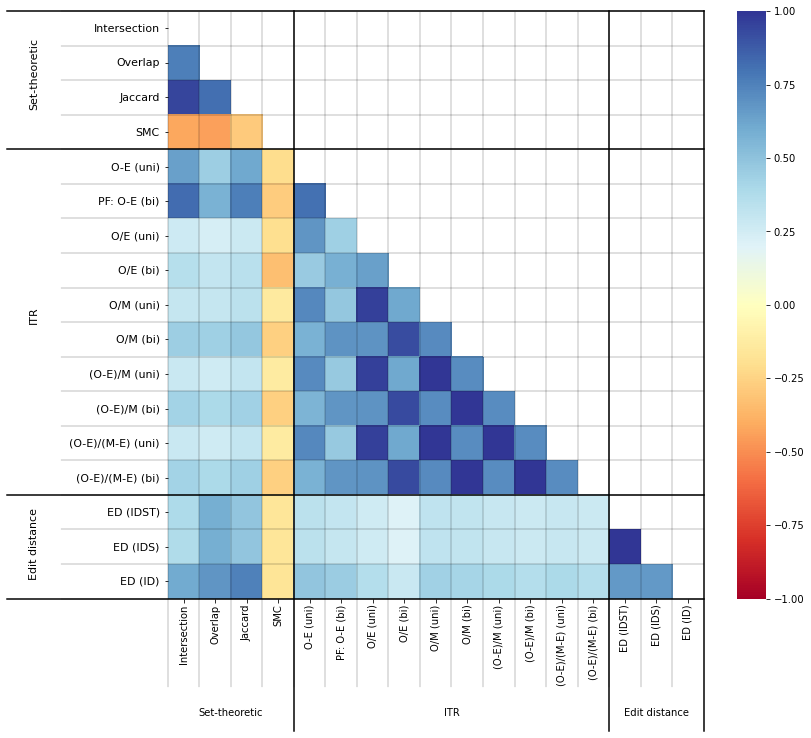

In [49]:
# and add labels to bottom
# July 28 2022
# CHECK THAT THE LABELS ON THE LEFT ARE IN THE RIGHT ORDER! (I think so because of SMT but still)
def add_line(ax, xpos, ypos, level):
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([ypos, ypos+ 1.2], [xpos, xpos], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([ypos+.05, ypos+ 1.35], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)
    
def add_line_specialLast(ax, xpos, ypos, level):
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([ypos-.085, ypos+ 1.2-.085], [xpos, xpos], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([ypos+.05, ypos+ 1.35], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def add_line_x(ax, xpos, ypos, level):
    #print('xpos', xpos)
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([xpos, xpos], [ypos, ypos], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([xpos, xpos], [ypos, ypos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)
    
def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in itertools.groupby(labels)]

# This is for y-axis
def label_group_bar_table(ax, df):
    scale = 1./df.index.size 
    #print('scale', scale)
    for level in range(df.index.nlevels):
        pos = df.index.size #index counts how many labels there are per group
        #print('pos', pos)
        for label, rpos in label_len(df.index,level):
            #print('label', label)
            #print('rpos', rpos)

            # this prints the text
            if label in ['Intersection', 'Overlap', 'Jaccard', 'SMC', 'O-E (uni)', 'PF: O-E (bi)', 'O/E (uni)', 'O/E (bi)', 'O/M (uni)', 'O/M (bi)', '(O-E)/M (uni)', '(O-E)/M (bi)', '(O-E)/(M-E) (uni)', '(O-E)/(M-E) (bi)', 'ED (IDST)', 'ED (IDS)', 'ED (ID)', 'ED (IDT)']:
                #xpos = -.2#
                xpos = -.115
                #add_line(ax, pos*scale, xpos, level)
                add_line(ax, pos*scale, xpos-0.085, level)
                pos -= rpos
                lypos = (pos + .4 * rpos)*scale    
                #lypos = (pos + .5 * rpos)*scale    
                ax.text(xpos+.1, lypos, label, ha='right', transform=ax.transAxes, fontsize=11) #rotation='vertical' here rotates all labels, incl. sub labels 
                    
            else:
                # This adjusts the position of the category labels on the left (x-axis)
                xpos = -.35 
                add_line(ax, pos*scale, xpos, level)
                # Adding something here seems to adjust the spacing/start location of the labels
                pos -= rpos
                # number changes position/start of category label text
                # I would somehow need to get the sum of all the sub-labels of that category, but I didn't and just visually adjusted it
                if label == 'ITR':
                    lypos = (pos + .5 * rpos)*scale
                    #print('lypos', lypos)
                    ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, fontsize=11, rotation='vertical')
                elif label == 'Set-theoretic':
                    lypos = (pos + .3 * rpos)*scale
                    #print('lypos', lypos)
                    ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, fontsize=11, rotation='vertical')   
                else:
                    lypos = (pos + .2 * rpos)*scale #.2
                    #print('lypos', lypos)
                    ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes, fontsize=11, rotation='vertical')
        
        #add_line(ax, pos*scale , xpos, level) #this is the last solid black line
        add_line_specialLast(ax, pos*scale , xpos, level)
        xpos -= .2
        
def add_line_x(ax, xpos, ypos, level):
    #print('ypos', ypos)       
    if level == 0:
        line = plt.Line2D([xpos, xpos], [ypos+.05, ypos+ 1.2], color='black', transform=ax.transAxes, linewidth=.25)
    elif level ==1:
        line = plt.Line2D([xpos, xpos], [ypos+.05, ypos+ 1.275], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len_x(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in itertools.groupby(labels)]

# This is for x-axis labels
def label_group_bar_table_x(ax, df):
    pos = 0
    scale = 1./df.index.size #.055
    #print('scale', scale)
    for level in range(df.index.nlevels):
        # level gives me 2 levels
        #print('level', level)
        pos = df.index.size #counts how many labels there are per group
        pos = pos -17 #This needs to be adjusted depdendent on measures included
        #print('pos1', pos)

        for label, rpos in label_len_x(df.index,level):
            #print('label', label)
            #and then I need 2 different y-values for the two levels
            #different x-values for each single label
            
            #xpos = 0 #(pos + .5 * rpos)*scale
            #lypos = -2
            
            #add_line_x(ax, lypos, xpos, level)

            #lypos = (pos + .5 * rpos)*scale
            #print('lypos', lypos)
            if label in ['Intersection', 'Overlap', 'Jaccard', 'SMC', 'O-E (uni)', 'PF: O-E (bi)', 'O/E (uni)', 'O/E (bi)', 'O/M (uni)', 'O/M (bi)', '(O-E)/M (uni)', '(O-E)/M (bi)', '(O-E)/(M-E) (uni)', '(O-E)/(M-E) (bi)', 'ED (IDST)', 'ED (IDS)', 'ED (ID)', 'ED (IDT)']:
                #print('rpos', rpos)
                #print('pos2', pos)
                ypos = -.01
                #xpos = 0.025 * pos + (.025 * rpos) #(pos + .5 * rpos)*scale
                xpos = (pos + .5 * rpos)*scale
                # rpos * x = 0.025
                pos += rpos
                #print('xpos level 1', xpos)
            
            #ax.text(lypos+.1, xpos, label, ha='center', transform=ax.transAxes, rotation='vertical') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                ax.text(xpos, ypos, label, ha='center', va='top', transform=ax.transAxes, rotation='vertical') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                #add_line_x(ax, xpos-.5*scale , -3.6*scale, level)
                add_line_x(ax, xpos-.5*scale , ypos-(3.25*scale), level)
            else:
                print('rpos level high', rpos)
                print('pos level high', pos)
                ypos = -.2
                #xpos = 0.025 * pos + (.025 * rpos) #(pos + .5 * rpos)*scale
                xpos = (pos + .5 * rpos)*scale
                # rpos * x = 0.025
                pos += rpos
                print('xpos level 0', xpos)
            
            #ax.text(lypos+.1, xpos, label, ha='center', transform=ax.transAxes, rotation='vertical') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                ax.text(xpos, ypos, label, ha='center', transform=ax.transAxes, rotation='horizontal') # This just adds the labels on the left again. the labels on the left have been created before with the other function similar name
                
                x_for_thick_line = pos * scale #so correct
                #add_line_x(ax, x_for_thick_line , ypos-.075, level) 
                add_line_x(ax, x_for_thick_line , ypos-1.275*scale, level) 
    #add_line_x(ax, 0 , -.275, 1) #manually insert y-axis bottom to add last sold think black line 

                
                
                
                
                
                
                
        
#corr = pd.read_csv('2022-08-25_Similarity_Exp1_AllWords_Clean-RelevantComparisons2.csv')
corr = pd.read_csv('2022-10-27_Similarity_Exp1_AllWords_Clean-RelevantComparisons2.csv') #CHANGE HERE
#print('corr', corr)
corr = corr.drop('lcs', axis=1)
corr = corr.drop('Group', axis=1)
corr = corr.drop('editdist', axis=1).drop('mod_editdist', axis=1).drop('pairedFreq', axis=1).drop('ITR2', axis=1).drop('ARC2', axis=1).drop('editdist_IDT', axis=1)
corr = corr.rename(columns={'intersection':'Intersection', 'overlap':'Overlap', 'jaccard':'Jaccard', 'OmEuni':'O-E (uni)', 'OmEbi':'PF: O-E (bi)', 'OdEuni':'O/E (uni)', 'OdEbi':"O/E (bi)", 'OdMuni':'O/M (uni)', 'OdMbi':'O/M (bi)', 'OmEdMuni':'(O-E)/M (uni)', 'OmEdMbi':'(O-E)/M (bi)', 'OmEdMmEMuni':'(O-E)/(M-E) (uni)', 'OmEdMmEMbi':'(O-E)/(M-E) (bi)', 'editdist_IDST':'ED (IDST)', 'editdist_IDS':'ED (IDS)', 'editdist_ID':'ED (ID)'})
corrMatrix = corr.corr()
#print('corrMatrix', corrMatrix)
corrMatrix.to_csv('Similarity_Exp1_AppendixCorrelation.csv')
corrMatrix_y = corrMatrix.reset_index()
corrMatrix_y = corrMatrix_y.drop(corrMatrix_y.columns[0], axis=1)
#manual calculation of mean correlation reported in manuscript
#print('corrMatrix_y', corrMatrix_y)



# I think this creates an index with two categories for each tuple
idx = pd.MultiIndex.from_tuples([('Intersection','Set-theoretic'), ('Overlap','Set-theoretic'), ('Jaccard','Set-theoretic'), ('SMC','Set-theoretic'), ('O-E (uni)','ITR'), ('PF: O-E (bi)','ITR'), ('O/E (uni)','ITR'), ("O/E (bi)",'ITR'), ('O/M (uni)','ITR'), ('O/M (bi)','ITR'), ('(O-E)/M (uni)','ITR'), ('(O-E)/M (bi)','ITR'), ('(O-E)/(M-E) (uni)','ITR'), ('(O-E)/(M-E) (bi)','ITR'), ('ED (IDST)','Edit distance'), ('ED (IDS)','Edit distance'), ('ED (ID)','Edit distance')], names=['first', 'second'])  
#print('idx', idx)

# and this mask is a separate plot with the white space at on the other side; so that corrs are only shown 1x
mask = np.triu(np.ones_like(corrMatrix_y, dtype=bool))
#print('mask', mask)

# forgot what this is but I assume the list of measures?
df_corr2 = corrMatrix_y.to_dict('list')
#print('df_corr2 list', df_corr2)
df_corr3 = pd.DataFrame(df_corr2, index=idx)
#print('df_corr2 DF (3)', df_corr3)

#df = test_table()
#print('df', df)

# Finally create the figure
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
#ax2 = fig.add_subplot(111)

sns.heatmap(df_corr3, mask=mask, cmap="RdYlBu", vmin=-1, vmax=1) #
ax.set_facecolor("white") #to make the top right triangle a white mask

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
#ax.rc('axes', labelsize=18)
ax.set_yticklabels(labels, fontsize=500)
ax.set_ylabel('')

# This is responsible for horizontal lines and labels on the left
label_group_bar_table(ax, df_corr3)

# I think this adjusts the row height and also vertical line length 
fig.subplots_adjust(bottom=.1*df_corr3.index.nlevels)


#plt.tight_layout()
#plt.show()

# Delete the labels on the x axis to manually add them to also show category label
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')

# This is responsible for vertical lines
label_group_bar_table_x(ax, df_corr3)

#fig.subplots_adjust(bottom=.1*df_corr3.index.nlevels)
#plt.tight_layout()
plt.savefig('Similarity_CorrMatrix_Exp1_20221027', dpi=600, bbox_inches='tight') #note to self, prior to 2022-10-27 used this file: Similarity_CorrMatrix_Exp1_20220825
plt.show()